In [1]:
import os

In [2]:
os.listdir('./severstal-steel-defect-detection/')

['sample_submission.csv',
 'test_images',
 'test_images.zip',
 'train.csv',
 'train_images',
 'train_images.zip']

In [3]:
from __future__ import print_function, division, absolute_import

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import OrderedDict

# import data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import image utils
import PIL
from PIL import Image, ImageOps, ImageEnhance

# import image processing
import scipy.ndimage as ndi
import scipy

# import image utilities
from skimage.morphology import binary_opening, disk, label, binary_closing

# import image augmentation
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, PadIfNeeded, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform,
    NoOp, RandomSizedCrop, RGBShift, VerticalFlip, RandomRotate90, Normalize, Resize, CropNonEmptyMaskIfExists
)
from albumentations.pytorch.transforms import ToTensor

# Import PyTorch
import torch
from torch import nn
from torch import optim
from torch.optim import Optimizer
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from torch.autograd import Variable
import torch.utils.model_zoo as model_zoo
from torch.nn import init
from torch.optim import lr_scheduler

import math
import os

import time

from tqdm import tqdm_notebook

import cv2
from skimage.morphology import binary_opening, disk, label

import segmentation_models_pytorch as smp

In [4]:
TRAIN_PATH = './severstal-steel-defect-detection/train_images/'
TEST_PATH = './severstal-steel-defect-detection/test_images/'

train = pd.read_csv('./severstal-steel-defect-detection/train.csv')


train_transforms = [
    OneOf([
        ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                         rotate_limit=15,
                         border_mode=cv2.BORDER_CONSTANT),
        OpticalDistortion(distort_limit=0.11, shift_limit=0.15,
                          border_mode=cv2.BORDER_CONSTANT),
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        NoOp()]),
    RandomSizedCrop(min_max_height=(100, 256),
                    height=256,
                    width=1600, p=0.3),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
]

In [5]:
train.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [6]:
df = pd.read_csv('./severstal-steel-defect-detection/train.csv')
# https://www.kaggle.com/amanooo/defect-detection-starter-u-net
df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
df['ClassId'] = df['ClassId'].astype(int)
df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
df['defects'] = df.count(axis=1)

In [7]:
df.head()

ClassId,1,2,3,4,defects
ImageId,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1
00031f466.jpg,NaN,NaN,NaN,NaN,0
000418bfc.jpg,NaN,NaN,NaN,NaN,0
000789191.jpg,NaN,NaN,NaN,NaN,0
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,1


In [8]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [9]:
def get_transforms(transforms, mean, std):
    list_transforms = []
    
    if transforms != None:
        list_transforms.extend(transforms)
        
    list_transforms.extend(
        [
            CropNonEmptyMaskIfExists(128,800),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms
    

class SteelDataset(Dataset):
    def __init__(self, df, data_folder, transforms, mean, std):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.transforms = get_transforms(transforms, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = np.asarray(Image.open(image_path))
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 1x4x256x1600
        
        return img, mask

    def __len__(self):
        return len(self.fnames)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
# define hyperparameters
test_split = 0.2
batch_size = 8
epochs = 30
learning_rate = 0.001
num_workers = 0
threshold = 0.5

In [12]:
# create dataset and data loaders (for FISH)
train_ds = SteelDataset(df, data_folder='./severstal-steel-defect-detection/', 
                        transforms=train_transforms, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
test_ds = SteelDataset(df, data_folder='./severstal-steel-defect-detection/', 
                        transforms=None, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

dataset_size = len(train_ds)

indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)

In [13]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [14]:
#source: https://www.kaggle.com/wh1tezzz/correct-dice-metrics-for-this-competition

def dice_channel_torch(probability, truth, threshold):
    batch_size = truth.shape[0]
    channel_num = truth.shape[1]
    mean_dice_channel = 0.
    with torch.no_grad():
        for i in range(batch_size):
            for j in range(channel_num):
                channel_dice = dice_single_channel(probability[i, j,:,:], truth[i, j, :, :], threshold)
                mean_dice_channel += channel_dice/(batch_size * channel_num)
    return mean_dice_channel


def dice_single_channel(probability, truth, threshold, eps = 1E-9):
    p = (probability.view(-1) > threshold).float()
    t = (truth.view(-1) > 0.5).float()
    dice = (2.0 * (p * t).sum() + eps)/ (p.sum() + t.sum() + eps)
    return dice

In [15]:
def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)

In [16]:
class BCESoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, w1=1, w2=1):
        super(BCESoftDiceLoss, self).__init__()
        self.bce_loss = nn.BCELoss(weight, size_average)
        self.w1 = w1
        self.w2 = w2
        
    def forward(self, logits, targets):
        # BCELoss2d
        probs        = torch.sigmoid(logits)
        probs_flat   = probs.view (-1)
        targets_flat = targets.view(-1)
        bce_loss = self.bce_loss(probs_flat, targets_flat)
        
        # SoftDiceLoss
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1  = probs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        soft_dice_loss = 1- score.sum()/num
        
        return self.w1 * bce_loss + self.w2 * soft_dice_loss

In [17]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()

    def forward(self, input, target):
        bce = F.binary_cross_entropy_with_logits(input, target)
        smooth = 1e-5
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice

In [18]:
"""
Lovasz-Softmax and Jaccard hinge loss in PyTorch
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)

Source:
https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py
"""

from __future__ import print_function, division

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse as ifilterfalse


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = mean(ious)    # mean accross images if per_image
    return 100 * iou


def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / float(union))
        ious.append(iou)
    ious = [mean(iou) for iou in zip(*ious)] # mean accross images if per_image
    return 100 * np.array(ious)


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
        neg_abs = - input.abs()
        loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
        return loss.mean()


def binary_xloss(logits, labels, ignore=None):
    """
    Binary Cross entropy loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      ignore: void class id
    """
    logits, labels = flatten_binary_scores(logits, labels, ignore)
    loss = StableBCELoss()(logits, Variable(labels.float()))
    return loss


# --------------------------- MULTICLASS LOSSES ---------------------------

class LovaszSoftmaxLoss(nn.Module):
    """
    Class wrapper for lovasz_softmax loss function.
    """
    def __init__(self):
        super(LovaszSoftmaxLoss, self).__init__()

    def forward(self, input, target):
        input = F.softmax(input, dim = 1)
        
        b, c, h, w = target.size()
        labels = torch.zeros(b,h,w)
        
        for i in range(1, c+1):
            labels += (target * i)[:,i-1,:,:]
        
        return lovasz_softmax(input, labels, classes='all')

def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes is 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    if probas.dim() == 3:
        # assumes output of a sigmoid layer
        B, H, W = probas.size()
        probas = probas.view(B, 1, H, W)
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


# --------------------------- HELPER FUNCTIONS ---------------------------
def isnan(x):
    return x != x


def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

In [19]:
encoder_name = 'efficientnet-b4'

In [20]:
model = smp.FPN(encoder_name, encoder_weights="imagenet", classes=4, activation=None)
model = model.to(device)
model

FPN(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (

In [21]:
optimizer = RAdam(model.parameters(), lr=learning_rate)
criterion = BCEDiceLoss()

In [22]:
train_stats = pd.DataFrame(columns = ['Epoch', 
                                      'Time per epoch', 
                                      'Avg time per step', 
                                      'Train loss',
                                      'DICE Train',
                                      'Test loss',
                                     'DICE Test',
                                     'IOU Test']) 

In [23]:
def train_model(model, device, trainloader, testloader, epochs, criterion, optimizer, train_stats):
    #train the model
    model = model.to(device)
    
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.15, patience=2)

    steps = 0
    running_loss = 0
    dice_train = 0
    for epoch in range(epochs):

        since = time.time()

        train_accuracy = 0
        dice_train = 0
        iou_train = 0
        
        for inputs, labels in tqdm_notebook(trainloader):
            steps += 1
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model.forward(inputs)

            loss = criterion(logps, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            dice_train += dice_channel_torch(logps, labels, threshold)
            
            #iou_train += iou_score(logps, labels)

        time_elapsed = time.time() - since

        test_loss = 0
        dice_test = 0
        iou_test = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)

                test_loss += batch_loss.item()

                # Calculate DICE
                dice_test += dice_channel_torch(logps, labels, threshold)
                
                iou_test += iou_score(logps, labels)

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Time per epoch: {time_elapsed:.4f}.. "
              f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
              f"Train loss: {running_loss/len(trainloader):.4f}.. "
              f"Test loss: {test_loss/len(testloader):.4f}.. "
              f"DICE Train: {dice_train/len(trainloader):.4f}.. "
              f"DICE Test: {dice_test/len(testloader):.4f}.. "
              #f"IOU Train: {iou_train/len(trainloader):.4f}.. "
              f"IOU Test: {iou_test/len(testloader):.4f}.. "
             )

        train_stats = train_stats.append({'Epoch': epoch + 1, 
                                          'Time per epoch':time_elapsed, 
                                          'Avg time per step': time_elapsed/len(trainloader), 
                                          'Train loss' : running_loss/len(trainloader),
                                          'Test loss' : test_loss/len(testloader),
                                          'DICE Train' : dice_train/len(trainloader),
                                          'DICE Test' : dice_test/len(testloader),
                                          'IOU Test' : iou_test/len(testloader)
                                         }, 
                                         ignore_index=True)
                
        scheduler.step(test_loss/len(testloader))
        running_loss = 0
        model.train()
        
    return model, train_stats

In [24]:
# train the model
torch.set_default_tensor_type("torch.cuda.FloatTensor")
model, train_stats = train_model(model, device, trainloader, testloader, epochs, criterion, optimizer, train_stats)


Epoch 1/30.. Time per epoch: 1003.3749.. Average time per step: 0.7982.. Train loss: 0.8381.. Test loss: 0.6996.. DICE Train: 0.7512.. DICE Test: 0.8379.. IOU Test: 0.4461.. 



Epoch 2/30.. Time per epoch: 1367.1655.. Average time per step: 1.0876.. Train loss: 0.8037.. Test loss: 0.7046.. DICE Train: 0.7799.. DICE Test: 0.8404.. IOU Test: 0.4235.. 



Epoch 3/30.. Time per epoch: 2298.8721.. Average time per step: 1.8289.. Train loss: 0.7966.. Test loss: 0.6960.. DICE Train: 0.7764.. DICE Test: 0.7534.. IOU Test: 0.4177.. 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 5/30.. Time per epoch: 1535.5912.. Average time per step: 1.2216.. Train loss: 0.7835.. Test loss: 0.6904.. DICE Train: 0.7981.. DICE Test: 0.8416.. IOU Test: 0.4397.. 



Epoch 6/30.. Time per epoch: 2712.2861.. Average time per step: 2.1577.. Train loss: 0.7736.. Test loss: 0.6679.. DICE Train: 0.8140.. DICE Test: 0.8721.. IOU Test: 0.5185.. 



Epoch 7/30.. Time per epoch: 1539.9325.. Average time per step: 1.2251.. Train loss: 0.7722.. Test loss: 0.6578.. DICE Train: 0.8047.. DICE Test: 0.8478.. IOU Test: 0.5068.. 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 9/30.. Time per epoch: 1560.5426.. Average time per step: 1.2415.. Train loss: 0.7648.. Test loss: 0.6613.. DICE Train: 0.8118.. DICE Test: 0.8322.. IOU Test: 0.4262.. 



Epoch 10/30.. Time per epoch: 1603.5558.. Average time per step: 1.2757.. Train loss: 0.7602.. Test loss: 0.6544.. DICE Train: 0.8167.. DICE Test: 0.8820.. IOU Test: 0.5252.. 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 16/30.. Time per epoch: 1496.8420.. Average time per step: 1.1908.. Train loss: 0.7499.. Test loss: 0.6449.. DICE Train: 0.8398.. DICE Test: 0.8750.. IOU Test: 0.5360.. 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 22/30.. Time per epoch: 1499.8623.. Average time per step: 1.1932.. Train loss: 0.7306.. Test loss: 0.6199.. DICE Train: 0.8653.. DICE Test: 0.9067.. IOU Test: 0.6010.. 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 27/30.. Time per epoch: 1500.2033.. Average time per step: 1.1935.. Train loss: 0.7246.. Test loss: 0.6164.. DICE Train: 0.8758.. DICE Test: 0.9071.. IOU Test: 0.5994.. 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
filename = 'efficientnet_b4_dice_' + str(epochs) + '.pth'

checkpoint = {'state_dict': model.state_dict()}

torch.save(checkpoint, filename)

In [26]:
# save training stats
train_stats.to_csv('efficientnet_b4_bcedice_stats.csv', index=False)

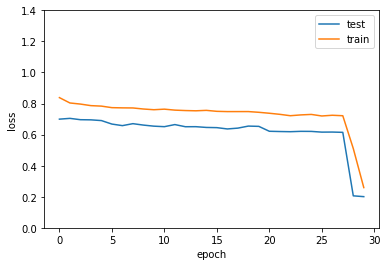

In [27]:
plt.plot(train_stats['Test loss'], label="test")
plt.plot(train_stats['Train loss'], label="train")
plt.ylim(0, 1.4)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc='best')

plt.show()

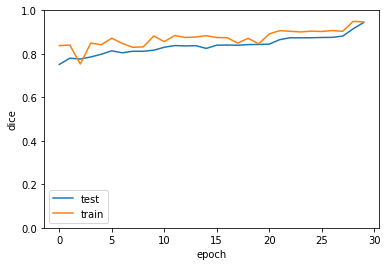

In [28]:
plt.plot(train_stats['DICE Train'], label="test")
plt.plot(train_stats['DICE Test'], label="train")
plt.ylim(0, 1)
plt.xlabel("epoch")
plt.ylabel("dice")
plt.legend(loc='best')

plt.show()

In [29]:
test_loss = 0
dice_test = 0
iou = 0
model.eval()
with torch.no_grad():
    for inputs, labels in tqdm_notebook(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)

        test_loss += batch_loss.item()

        # Calculate DICE
        dice_test += dice_channel_torch(logps, labels, threshold)
        
        iou += iou_score(logps, labels)
        
test_loss = test_loss / len(testloader)
dice_test = dice_test / len(testloader)
iou = iou / len(testloader)

In [30]:
print('Test loss: {}'.format(test_loss))
print('DICE test: {}'.format(dice_test))
print('IOU test: {}'.format(iou))

Test loss: 0.19616832107542054
DICE test: 0.9488622546195984
IOU test: 0.627276287755503


In [31]:
checkpoint = torch.load(filename)

In [32]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [33]:
model

FPN(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (

In [34]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [35]:
class TestDataset(Dataset):
    '''Dataset for test prediction'''
    def __init__(self, root, df, mean, std):
        self.root = root
        df['ImageId'] = df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
        self.fnames = df['ImageId'].unique().tolist()
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname)
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return fname, images

    def __len__(self):
        return self.num_samples

In [36]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
sample_submission_path = './severstal-steel-defect-detection/sample_submission.csv'
test_data_folder = TEST_PATH
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_data_folder, df, mean, std),
    batch_size=2,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [37]:
torch.cuda.empty_cache()

In [38]:
model = model.eval()

In [39]:
def post_process(probability, threshold, min_size):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 1600), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [40]:
best_threshold = threshold
min_size = 3500

# start prediction
predictions = []
for i, batch in enumerate(tqdm_notebook(testset)):
    fnames, images = batch
    batch_preds = torch.sigmoid(model(images.to(device)))
    batch_preds = batch_preds.detach().cpu().numpy()
    for fname, preds in zip(fnames, batch_preds):
        for cls, pred in enumerate(preds):
            pred, num = post_process(pred, best_threshold, min_size)
            rle = mask2rle(pred)
            name = fname + f"_{cls+1}"
            predictions.append([name, rle])

# save predictions to submission.csv
df = pd.DataFrame(predictions, columns=['ImageId_ClassId', 'EncodedPixels'])
df.to_csv("submission.csv", index=False)

In [41]:
df.head()

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,
1,004f40c73.jpg_2,
2,004f40c73.jpg_3,
3,004f40c73.jpg_4,
4,006f39c41.jpg_1,


In [42]:
df.EncodedPixels.count()

7204